## Decision Analytics Final Project
### Question: What is the best combination of tourist attractions in NYC that a travel agency can put together in order to provide the best tour experience? 
#### Team Members: Megan, Jhanvi, Hannah, Kaia

## Preprocessing

In [1]:
# impor
import numpy as np
from gurobipy import *
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
survey_table = pd.read_csv("survey_final_table.csv")
nyc = pd.read_csv("nyc_attractions.csv")

In [3]:
# Load the survey results table
survey_table.head()

,Unnamed: 0,Group,Proba,Nature,Museum,Family,Activity,Walking,Theatre,Landmarks
0,0,3.0,0.25,3.800000,2.000000,3.400000,4.400000,3.000000,2.400000,2.800000
1,1,2.0,0.20,1.000000,3.750000,3.000000,1.250000,2.250000,3.500000,3.000000
2,2,1.0,0.30,4.333333,3.666667,3.166667,1.833333,4.166667,3.333333,1.333333
3,3,0.0,0.25,5.000000,3.200000,1.800000,4.200000,2.600000,3.200000,1.400000


In [4]:
# Load the NYC tourist attraction category table
nyc.head()

,AttractionID,AttractionName,CostPerVisit,Nature,Museum,Family,Active,Walking,Theatre,Landmark
0,1,Central Park,0.0,3,2,3,3,3,1,3
1,2,The National 9/11 Memorial & Museum,33.0,1,3,2,1,2,1,2
2,3,The Metropolitan Museum of Art,30.0,1,3,2,1,2,1,2
3,4,Empire State Building,79.0,1,1,3,1,1,1,3
4,5,The High Line,0.0,3,1,3,3,3,1,3


In [5]:
# 
nyc_short = nyc.drop(labels=['AttractionID', 'AttractionName', 'CostPerVisit'],axis=1)
nyc_short.head()

,Nature,Museum,Family,Active,Walking,Theatre,Landmark
0,3,2,3,3,3,1,3
1,1,3,2,1,2,1,2
2,1,3,2,1,2,1,2
3,1,1,3,1,1,1,3
4,3,1,3,3,3,1,3


In [6]:
nyc_short = nyc_short.rename(columns={
    "Landmark": "Landmarks",
    "Active":"Activity"
})
nyc_short.head()

,Nature,Museum,Family,Activity,Walking,Theatre,Landmarks
0,3,2,3,3,3,1,3
1,1,3,2,1,2,1,2
2,1,3,2,1,2,1,2
3,1,1,3,1,1,1,3
4,3,1,3,3,3,1,3


In [7]:
# Clean up survey table
survey_table_short = survey_table.drop(labels=['Unnamed: 0', 'Group', 'Proba'], axis=1)
survey_table_short

,Nature,Museum,Family,Activity,Walking,Theatre,Landmarks
0,3.800000,2.000000,3.400000,4.400000,3.000000,2.400000,2.800000
1,1.000000,3.750000,3.000000,1.250000,2.250000,3.500000,3.000000
2,4.333333,3.666667,3.166667,1.833333,4.166667,3.333333,1.333333
3,5.000000,3.200000,1.800000,4.200000,2.600000,3.200000,1.400000


In [8]:
attractions1 = nyc.to_dict()

#### Calculate the dot product of survey table responses and attraction relevance score so that we can get the happiness score of each attraction for each group

In [9]:
attraction_user_product = np.dot(nyc_short, survey_table_short.T)
attraction_user_product

array([[58.6       , 42.5       , 55.16666667, 54.6       ],
       [35.        , 33.5       , 37.83333333, 33.6       ],
       [35.        , 33.5       , 37.83333333, 33.6       ],
       [34.2       , 29.75      , 30.83333333, 27.8       ],
       [56.6       , 38.75      , 51.5       , 51.4       ],
       [34.2       , 29.75      , 30.83333333, 27.8       ],
       [38.        , 30.75      , 35.16666667, 32.8       ],
       [36.2       , 32.5       , 35.16666667, 31.8       ],
       [30.        , 27.75      , 31.66666667, 29.6       ],
       [30.8       , 26.75      , 27.66666667, 26.        ],
       [41.        , 33.        , 39.33333333, 35.4       ],
       [42.2       , 37.5       , 45.33333333, 40.4       ],
       [38.2       , 30.        , 38.        , 34.        ],
       [34.2       , 29.75      , 30.83333333, 27.8       ],
       [36.8       , 31.25      , 36.        , 31.2       ],
       [38.2       , 36.25      , 38.83333333, 35.        ],
       [37.2       , 32.

The above matrix demonstrate the composite "attraction score" of each tourist site for each tourist group archetype. For example, the first number 52 is the attraction score of central park for Group 0 (Adventurers). It is calculated by SUM(category i preferences score * this site's relevance to category i). 

## Optimization task
We tried two coding variations for our formulation of the problem:
* **Variation #1**: Hard-code At
This variation is closest to our formula where the agency will commit to a maximum total number of attractions then run the model for the best attractions to choose.

* **Variation #2**: Let Gurobi chooses an At
This variation is inspired by the L9-Aircraft.ipynb notebook. We add At as a decision variable and see if gurobi can choose the best At.

In [10]:
# Set up the Parameters
budget = 100 # Total budget constraint
demographic_weights = list(survey_table['Proba'])

demographic_weights

[0.25, 0.2, 0.3, 0.25]

In [11]:
# function to filter the nyc attraction table by selected attraction
def filtered_table(attractionList):
    table = nyc[nyc['AttractionID'].isin(attractionList)]
    return table

In [12]:
# function to call the model

def NYCTourModel(model):
    # Objective Function
    model.setObjective(quicksum(demographic_weights[j] * quicksum(a[i] * attraction_user_product[i][j] for i in range(24)) for j in range(3)), GRB.MAXIMIZE)

    ### Constraints ###

    # Budget Constraint
    model.addConstr(
        quicksum(a[i] * nyc["CostPerVisit"][i] for i in range(24)) <= budget, "Budget"
    )

    # Total no.of attractions Constraint 
    model.addConstr(
        quicksum(a[i] for i in range(24)) <= At, "Duration"
    )

    # Optimize
    model.optimize()

    # Print Results
    if model.status == GRB.OPTIMAL:
        selected_attractions = [i + 1 for i in range(24) if a[i].X > 0.5]
        print("Optimal Attractions:", selected_attractions)
        print("Maximum Happiness:", model.objVal)
    else:
        print("No optimal solution found.")
        
    return filtered_table(selected_attractions)
    

### Variation #1

In [13]:
## Initialize Model
model_var1 = Model("Variation_1")

## Decision variables
# Stage 1 decision varable: A (decide on a max number of attractions - in this case, 10)
At = 10
# Stage 2 decision variable: a (decide on which attraction to go to)
a = model_var1.addVars(24, vtype=GRB.BINARY, name="a")

## Call the model
variation1 = NYCTourModel(model_var1)

## Print results in ipython
display(variation1)

Restricted license - for non-production use only - expires 2026-11-23
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1250U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2 rows, 24 columns and 34 nonzeros
Model fingerprint: 0xe2907114
Variable types: 0 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+02]
Found heuristic solution: objective 291.5500000
Presolve removed 0 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 15 columns, 22 nonzeros
Found heuristic solution: objective 217.9000000
Variable types: 0 continuous, 15 integer (14 binary)
Found heuristic solution: objective 307.5000000

Root relaxation: objective 3.219500e+02, 3 iterations, 0.00 seconds (0.00 work units)



,AttractionID,AttractionName,CostPerVisit,Nature,Museum,Family,Active,Walking,Theatre,Landmark
0,1,Central Park,0.0,3,2,3,3,3,1,3
4,5,The High Line,0.0,3,1,3,3,3,1,3
10,11,Brooklyn Bridge,0.0,2,1,3,1,2,1,3
11,12,American Museum of Natural History,30.0,2,3,3,1,2,1,2
15,16,NY Public Library,0.0,1,2,2,1,2,2,3
17,18,MoMA,30.0,1,3,3,1,2,2,2
19,20,Bryant Park,0.0,2,1,3,3,3,1,3
21,22,Shopping on Fifth Avenue,0.0,1,1,3,1,3,1,3
22,23,Shopping at SoHo,0.0,1,1,3,1,3,1,3
23,24,Roosevelt Island,0.0,2,1,3,3,2,1,3


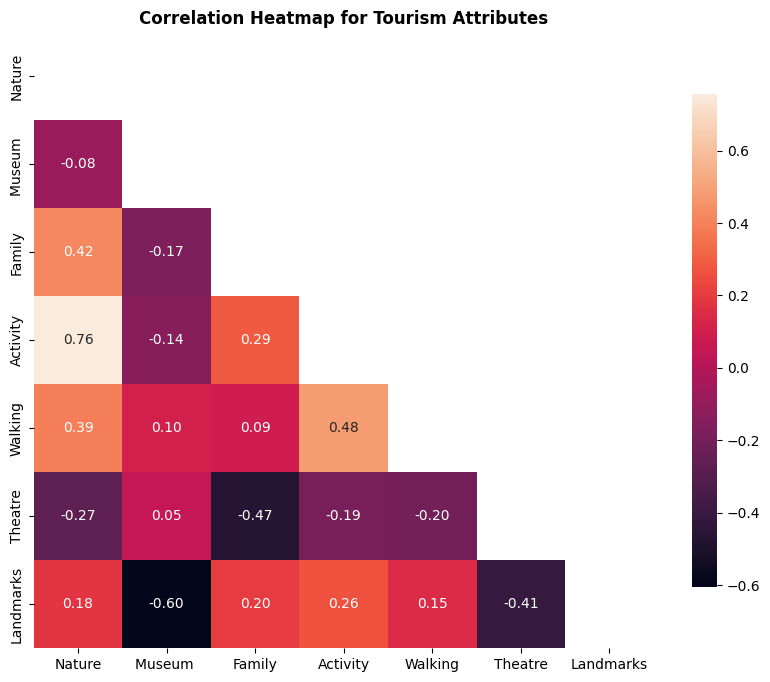

In [14]:
# see if correlation between attribute play into the bias
import seaborn as sns

# Compute the correlation matrix
corr = nyc_short.corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Create the heatmap with the mask and display the correlation values
sns.heatmap(
    corr,
    mask=mask,
    annot=True,  # Display the correlation values
    fmt=".2f",   # Format to 2 decimal places
    cbar_kws={"shrink": 0.8}
)

# Add a title
plt.title("Correlation Heatmap for Tourism Attributes", fontweight="bold")

# Show the plot
plt.show()

### Write some conclusions about the places chosen: cost per visit and distribution of attributes. It also did not pick any locations with cost > 30

### Variation 2

In [15]:
## Initialize Model
model = Model("Variation_2")

## Decision variables
# Stage 1 decision varable: A (decide on a max number of attractions - in this case, 5)
At = model.addVar(vtype=GRB.INTEGER, name="At")
# Stage 2 decision variable: a (decide on which attraction to go to)
a = model.addVars(24, vtype=GRB.BINARY, name="a")

# Call the model
variation2 = NYCTourModel(model)

#print results
display(variation2)

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1250U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2 rows, 25 columns and 35 nonzeros
Model fingerprint: 0x932ffb8b
Variable types: 0 continuous, 25 integer (24 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+02, 1e+02]
Found heuristic solution: objective -0.0000000
Found heuristic solution: objective 497.1000000
Presolve removed 2 rows and 25 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 3: 502.5 497.1 -0 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.025000000000e+02, best bound 5.025000000000

,AttractionID,AttractionName,CostPerVisit,Nature,Museum,Family,Active,Walking,Theatre,Landmark
0,1,Central Park,0.0,3,2,3,3,3,1,3
4,5,The High Line,0.0,3,1,3,3,3,1,3
6,7,Statue of Liberty,0.0,2,1,3,1,1,1,3
7,8,Times Square,0.0,1,1,2,1,2,2,3
9,10,Grand Central Terminal,0.0,1,1,2,1,1,1,3
10,11,Brooklyn Bridge,0.0,2,1,3,1,2,1,3
11,12,American Museum of Natural History,30.0,2,3,3,1,2,1,2
12,13,Staten Island Ferry,0.0,2,1,3,1,2,1,2
14,15,Chelsea Market,0.0,1,1,2,1,3,1,3
15,16,NY Public Library,0.0,1,2,2,1,2,2,3


In [16]:
# see if variation 2 picks all the free location
free_locations = nyc[nyc['CostPerVisit'] == 0]
variation2_free = variation2[variation2['CostPerVisit'] == 0]

free_locations['AttractionID'] == variation2_free['AttractionID']

0     True
4     True
6     True
7     True
9     True
10    True
12    True
14    True
15    True
16    True
19    True
21    True
22    True
23    True
Name: AttractionID, dtype: bool

### Write something about the model just maximizes free locations ==> we feel like we need to limit At ==> we would need data on travel time and makes this more complicated

## What-If Analysis: 
We will rerun variation 1 through the following scenarios:
- Changing total butgets 
- Changing probabilities of tourist archetype
- Changing tourist weighting

### Scenario 1: Budget sensitivity
We reran the model through three cases of total budget $C_t$:
- $C_t$ = $1000 (non-binding)
- $C_t$ = $30 (more restrictive)
- $C_t$ = $20 (most restrictive)

In [17]:
# Set up new Parameters
whatif_budget = (1000, 30, 20)
demographic_weights = list(survey_table['Proba'])

In [18]:
for C in whatif_budget:
    budget = C
    # Initialize Model
    model = Model(f"C={C}")

    ## Decision variables
    # Stage 1 decision varable: A (decide on a max number of attractions - in this case, 10)
    At = 10
    # Stage 2 decision variable: a (decide on which attraction to go to)
    a = model.addVars(24, vtype=GRB.BINARY, name="a")

    ## Call the model
    whatif = NYCTourModel(model).copy()

    whatif['Different?'] = whatif['AttractionID'].apply(lambda x: False if int(x) in set(variation1['AttractionID'].astype(int)) else True)

    ## Display results
    print()
    print(f"C = {C}")
    display(whatif)
    print()

print("*The 'Different?' column shows whether the row is different from variation 1's results with True = Different.")

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1250U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2 rows, 24 columns and 34 nonzeros
Model fingerprint: 0x04f326ff
Variable types: 0 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+03]
Found heuristic solution: objective 274.3500000
Presolve removed 2 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 321.95 274.35 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.219500000000e+02, best bound 3.219500000000e+02, gap 0.0000%
Optimal Attractions: [1, 5, 11

,AttractionID,AttractionName,CostPerVisit,Nature,Museum,Family,Active,Walking,Theatre,Landmark,Different?
0,1,Central Park,0.0,3,2,3,3,3,1,3,False
4,5,The High Line,0.0,3,1,3,3,3,1,3,False
10,11,Brooklyn Bridge,0.0,2,1,3,1,2,1,3,False
11,12,American Museum of Natural History,30.0,2,3,3,1,2,1,2,False
15,16,NY Public Library,0.0,1,2,2,1,2,2,3,False
17,18,MoMA,30.0,1,3,3,1,2,2,2,False
19,20,Bryant Park,0.0,2,1,3,3,3,1,3,False
21,22,Shopping on Fifth Avenue,0.0,1,1,3,1,3,1,3,False
22,23,Shopping at SoHo,0.0,1,1,3,1,3,1,3,False
23,24,Roosevelt Island,0.0,2,1,3,3,2,1,3,False



Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1250U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2 rows, 24 columns and 34 nonzeros
Model fingerprint: 0x523a582c
Variable types: 0 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 3e+01]
Found heuristic solution: objective 287.8000000
Presolve removed 2 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 317.4 287.8 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.174000000000e+02, best bound 3.174000000000e+02, gap 0.0000%
Optimal Attractions: [1, 5, 11,

,AttractionID,AttractionName,CostPerVisit,Nature,Museum,Family,Active,Walking,Theatre,Landmark,Different?
0,1,Central Park,0.0,3,2,3,3,3,1,3,False
4,5,The High Line,0.0,3,1,3,3,3,1,3,False
10,11,Brooklyn Bridge,0.0,2,1,3,1,2,1,3,False
11,12,American Museum of Natural History,30.0,2,3,3,1,2,1,2,False
12,13,Staten Island Ferry,0.0,2,1,3,1,2,1,2,True
15,16,NY Public Library,0.0,1,2,2,1,2,2,3,False
19,20,Bryant Park,0.0,2,1,3,3,3,1,3,False
21,22,Shopping on Fifth Avenue,0.0,1,1,3,1,3,1,3,False
22,23,Shopping at SoHo,0.0,1,1,3,1,3,1,3,False
23,24,Roosevelt Island,0.0,2,1,3,3,2,1,3,False



Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1250U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2 rows, 24 columns and 34 nonzeros
Model fingerprint: 0xbab0e688
Variable types: 0 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [2e+01, 4e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 2e+01]
Found heuristic solution: objective 287.2000000
Presolve removed 2 rows and 24 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 12 available processors)

Solution count 2: 312 287.2 

Optimal solution found (tolerance 1.00e-04)
Best objective 3.120000000000e+02, best bound 3.120000000000e+02, gap 0.0000%
Optimal Attractions: [1, 5, 11, 1

,AttractionID,AttractionName,CostPerVisit,Nature,Museum,Family,Active,Walking,Theatre,Landmark,Different?
0,1,Central Park,0.0,3,2,3,3,3,1,3,False
4,5,The High Line,0.0,3,1,3,3,3,1,3,False
10,11,Brooklyn Bridge,0.0,2,1,3,1,2,1,3,False
12,13,Staten Island Ferry,0.0,2,1,3,1,2,1,2,True
14,15,Chelsea Market,0.0,1,1,2,1,3,1,3,True
15,16,NY Public Library,0.0,1,2,2,1,2,2,3,False
19,20,Bryant Park,0.0,2,1,3,3,3,1,3,False
21,22,Shopping on Fifth Avenue,0.0,1,1,3,1,3,1,3,False
22,23,Shopping at SoHo,0.0,1,1,3,1,3,1,3,False
23,24,Roosevelt Island,0.0,2,1,3,3,2,1,3,False



*The 'Different?' column shows whether the row is different from variation 1's results with True = Different.


### Scenario 2: Tourist archetype sensitivity
We will rerun the model through three cases of $p_s$:
- $p_s$ = [1, 0, 0, 0]: only 1 tourist group
- $p_s$ = [0, 0.8, 0.1, 0.1]: mostly 1 tourist group with some shares of others
- $p_s$ = [0.25, 0.25, 0.25, 0.25]: even split

In [19]:
# Set up new Parameters
budget = 100
whatif_weights = ([1,0,0,0], [0,0.8,0.1,0.1],[0.25, 0.25, 0.25, 0.25])

In [20]:
com_table = pd.DataFrame()

for p in whatif_weights:
    demographic_weights = p
    # Initialize Model
    model = Model(f"p={p}")

    ## Decision variables
    # Stage 1 decision varable: A (decide on a max number of attractions - in this case, 10)
    At = 10
    # Stage 2 decision variable: a (decide on which attraction to go to)
    a = model.addVars(24, vtype=GRB.BINARY, name="a")

    ## Call the model
    whatif = NYCTourModel(model)

    temp = whatif['AttractionID'].rename(f"p={p}")

    ## Get results
    com_table = pd.concat([com_table, temp], axis=1)

display(com_table)

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (22631.2))

CPU model: 12th Gen Intel(R) Core(TM) i7-1250U, instruction set [SSE2|AVX|AVX2]
Thread count: 10 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 2 rows, 24 columns and 34 nonzeros
Model fingerprint: 0x92ce14e5
Variable types: 0 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+02]
  Objective range  [3e+01, 6e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+01, 1e+02]
Found heuristic solution: objective 411.6000000
Presolve removed 0 rows and 9 columns
Presolve time: 0.00s
Presolved: 2 rows, 15 columns, 22 nonzeros
Found heuristic solution: objective 344.6000000
Variable types: 0 continuous, 15 integer (13 binary)
Found heuristic solution: objective 435.6000000

Root relaxation: objective 4.604000e+02, 3 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Wo

,"p=[1, 0, 0, 0]","p=[0, 0.8, 0.1, 0.1]","p=[0.25, 0.25, 0.25, 0.25]"
0,1.0,1.0,1.0
4,5.0,5.0,5.0
10,11.0,NaN,11.0
11,12.0,12.0,12.0
12,13.0,NaN,NaN
17,18.0,18.0,18.0
19,20.0,20.0,20.0
21,22.0,22.0,22.0
22,23.0,23.0,23.0
23,24.0,24.0,24.0


In [21]:
# rows with NaN shows difference between the scenarios, rows without nans show attractions that the model consistently picks or is biased towards
# biased locations - kinda makes sense
unchanged = nyc[nyc['AttractionID'].isin(com_table.dropna(axis=0).iloc[:,0])]

unchanged

,AttractionID,AttractionName,CostPerVisit,Nature,Museum,Family,Active,Walking,Theatre,Landmark
0,1,Central Park,0.0,3,2,3,3,3,1,3
4,5,The High Line,0.0,3,1,3,3,3,1,3
11,12,American Museum of Natural History,30.0,2,3,3,1,2,1,2
17,18,MoMA,30.0,1,3,3,1,2,2,2
19,20,Bryant Park,0.0,2,1,3,3,3,1,3
21,22,Shopping on Fifth Avenue,0.0,1,1,3,1,3,1,3
22,23,Shopping at SoHo,0.0,1,1,3,1,3,1,3
23,24,Roosevelt Island,0.0,2,1,3,3,2,1,3


In [22]:
# average user rating across all groups for each attraction
top_location = pd.concat([nyc[['AttractionID','AttractionName','CostPerVisit']],pd.Series(attraction_user_product.mean(axis=1), name='Average Rating')], axis=1).sort_values(by='Average Rating', ascending=False)

top_location['Chosen?'] = top_location['AttractionID'].apply(lambda x: True if x in set(unchanged['AttractionID']) else False)

top_location

,AttractionID,AttractionName,CostPerVisit,Average Rating,Chosen?
0,1,Central Park,0.0,52.716667,True
4,5,The High Line,0.0,49.562500,True
19,20,Bryant Park,0.0,46.029167,True
23,24,Roosevelt Island,0.0,43.025000,True
11,12,American Museum of Natural History,30.0,41.358333,True
17,18,MoMA,30.0,40.933333,True
10,11,Brooklyn Bridge,0.0,37.183333,False
15,16,NY Public Library,0.0,37.070833,False
21,22,Shopping on Fifth Avenue,0.0,36.654167,True
22,23,Shopping at SoHo,0.0,36.654167,True
